In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import efficientnet

trident 0.5.0
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.4.0.
Using pillow image backend.
Pillow version:6.2.1.


![Alt text](../images/porndetector.jpg)

![Alt text](../images/pornclass.jpg)

In [3]:
dataset=load_examples_data('nsfw')
dataset.image_transform_funcs=[
    random_adjust_gamma(gamma=(0.8,1.2)),
    #隨機調整圖片明暗gamma 0.6~1.4之間
    random_adjust_contrast(scale=(0.8, 1.2)),
    #隨機調整圖片對比度
    random_adjust_hue(),
    #隨機調整色相
    add_noise(intensity=np.random.choice(np.arange(0.001,0.1,0.0005))),
    #隨機加入噪音
    random_center_crop(224,224,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

#數據集的圖片處理流程image_transform_funcs為標準imagenet標準化
#加上隨機調整色相random_adjust_hue以及隨機等比例縮放中心裁切random_center_crop

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
training images: 10001  test images:5746
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.


![Alt text](../images/nsfw_data.jpg)

![Alt text](../images/EfficientNet.jpg)

In [4]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=efficientnet.EfficientNetB0(include_top=True,
             pretrained=True,
             input_shape=(3,224,224),
             classes=5)

#只開放全連接層以及最後一組Efficient Block開放學習
effb0.model.trainable=False
effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True


model file is already existing, donnot need download again.
4013953 parameters have set untrainable
6405 parameters have set trainable
717232 parameters have set trainable


In [5]:
#召回率
def recall(output,target):
    input_tensor=output.clone().detach()
    target_tensor=target.clone().detach()
    input_tensor=argmax(input_tensor,1).squeeze() #將預測結果透過argmax，產生類別的判斷
    input_tensor=input_tensor.eq(3).float() #檢查那些預測結果是3(色情圖片)
    target_tensor=target_tensor.eq(3).float() #檢查那些答案是3(色情圖片)
    return (input_tensor*target_tensor).sum()/max(target_tensor.sum(),1)
#input_tensor*target_tensor兩個相乘結果為1，則表示實際是色情圖片且正確被預測
#除以所有的色情圖片總數target_tensor.sum()就可以獲得召回率

In [6]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==2:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==10:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==15:
            training_context['current_model'].block6b.trainable=True #透過training_context切換模型指定層的trainable狀態
    

In [7]:
effb0=effb0\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_loss(F1ScoreLoss,name='f1_score')\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(recall,name='recall')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/effb0_v2.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_callbacks(CustomCallback())

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定max_min_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制


effb0.summary()
#檢視模型結構

CrossEntropyLoss signature:[('output', [1000]), ('target', [1000])]
f1_score signature:[('output', [1000]), ('target', [1000])]
accuracy signature:[('output', [1000]), ('target', [1000])]
recall signature:[('output', [1000]), ('target', [1000])]
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
stem                                     [-1, 32, 112, 112]                                   0         0.0         
batch_norm_50                            [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
depthwise_conv2d_17                      [-1, 32, 112, 112]    [32, 1, 3, 3]                  288       7212800.0   
batch_norm_51                            [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
block1a_dwconv                          

In [8]:
#設定學習計畫
#指定資料提供者
#跑10個epoach
#minibatch_size為16
#每10個批次列印一次訓練進度
#每100個批次顯示一次loss_metric_curve
#每10個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(dataset)\
    .repeat_epochs(10)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(10,unit='batch')

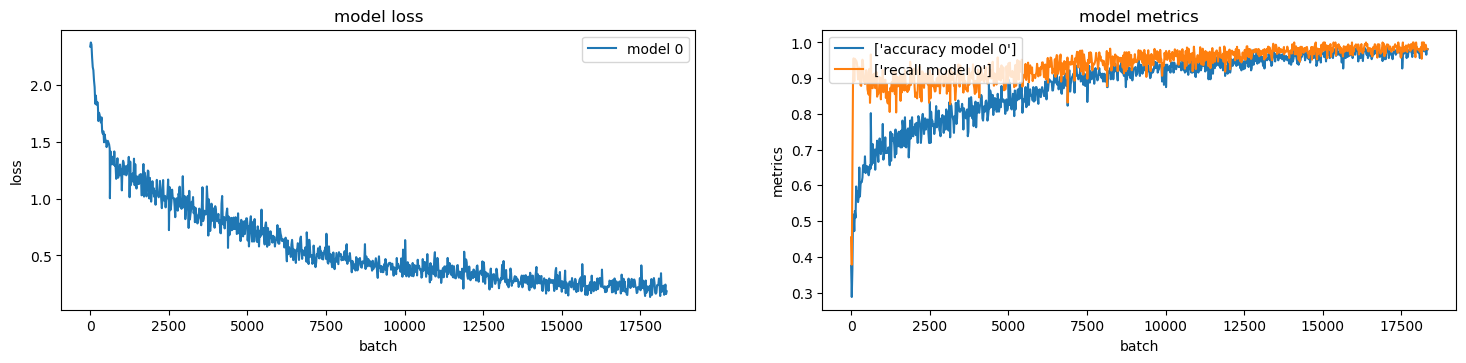

model 0      Step: 12s938ms | Loss: 0.228   | accuracy: 97.188% ,recall: 98.889%  | learning rate: 3.125e-05 | epoch: 29  ( 200/626 )
model 0      Step: 12s295ms | Loss: 0.263   | accuracy: 96.562% ,recall: 98.452%  | learning rate: 3.125e-05 | epoch: 29  ( 220/626 )
model 0      Step: 13s674ms | Loss: 0.267   | accuracy: 95.938% ,recall: 96.514%  | learning rate: 3.125e-05 | epoch: 29  ( 240/626 )
model 0      Step: 12s18ms  | Loss: 0.235   | accuracy: 97.500% ,recall: 99.018%  | learning rate: 3.125e-05 | epoch: 29  ( 260/626 )
model 0      Step: 12s225ms | Loss: 0.225   | accuracy: 96.875% ,recall: 99.500%  | learning rate: 3.125e-05 | epoch: 29  ( 280/626 )


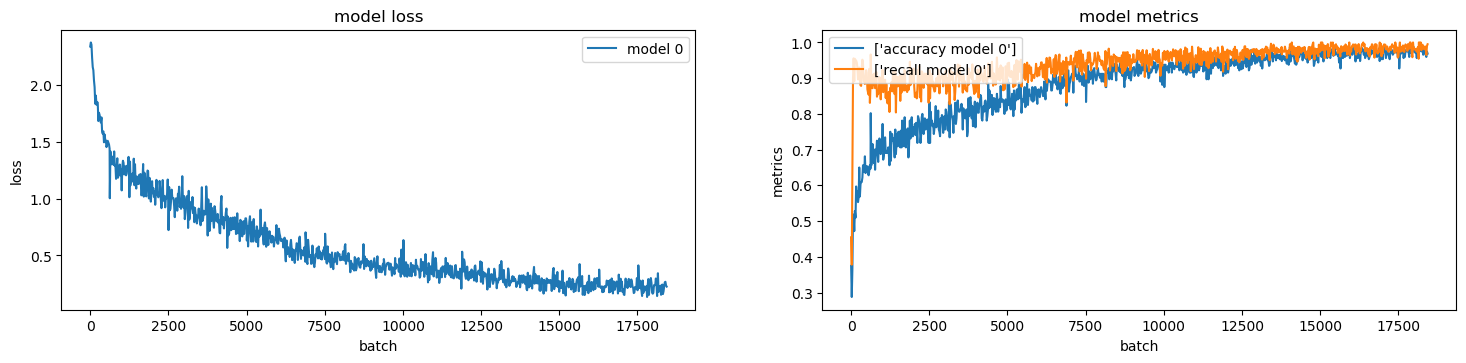

model 0      Step: 12s971ms | Loss: 0.249   | accuracy: 96.875% ,recall: 99.444%  | learning rate: 3.125e-05 | epoch: 29  ( 300/626 )
model 0      Step: 12s566ms | Loss: 0.235   | accuracy: 96.562% ,recall: 97.706%  | learning rate: 3.125e-05 | epoch: 29  ( 320/626 )
model 0      Step: 12s105ms | Loss: 0.191   | accuracy: 98.125% ,recall: 98.105%  | learning rate: 3.125e-05 | epoch: 29  ( 340/626 )
model 0      Step: 12s737ms | Loss: 0.207   | accuracy: 97.812% ,recall: 97.946%  | learning rate: 3.125e-05 | epoch: 29  ( 360/626 )
model 0      Step: 12s92ms  | Loss: 0.292   | accuracy: 95.938% ,recall: 96.460%  | learning rate: 3.125e-05 | epoch: 29  ( 380/626 )


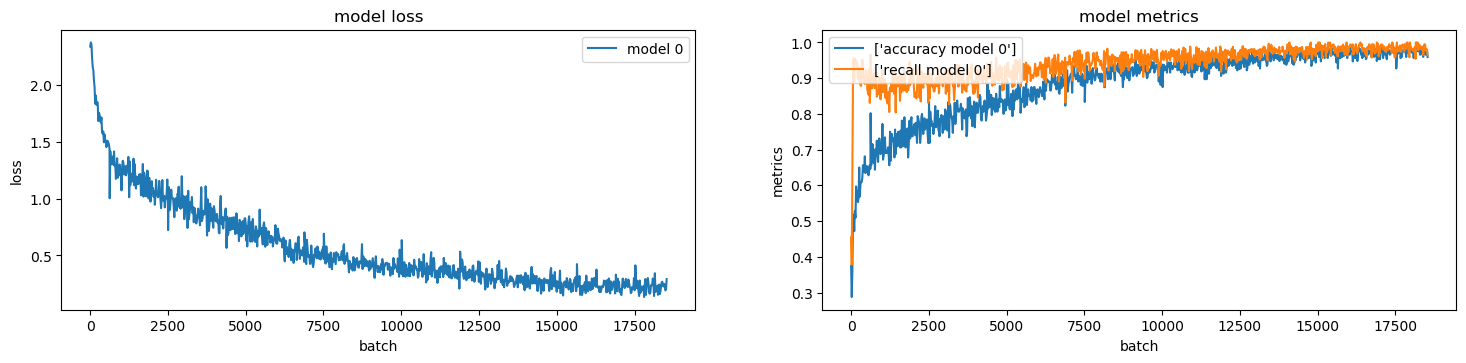

model 0      Step: 12s946ms | Loss: 0.289   | accuracy: 96.562% ,recall: 97.764%  | learning rate: 3.125e-05 | epoch: 29  ( 400/626 )
model 0      Step: 12s224ms | Loss: 0.330   | accuracy: 95.938% ,recall: 97.460%  | learning rate: 3.125e-05 | epoch: 29  ( 420/626 )
model 0      Step: 17s690ms | Loss: 0.202   | accuracy: 98.438% ,recall: 100.000% | learning rate: 3.125e-05 | epoch: 29  ( 440/626 )
model 0      Step: 12s706ms | Loss: 0.226   | accuracy: 96.562% ,recall: 97.661%  | learning rate: 3.125e-05 | epoch: 29  ( 460/626 )
model 0      Step: 12s775ms | Loss: 0.153   | accuracy: 98.125% ,recall: 99.375%  | learning rate: 3.125e-05 | epoch: 29  ( 480/626 )


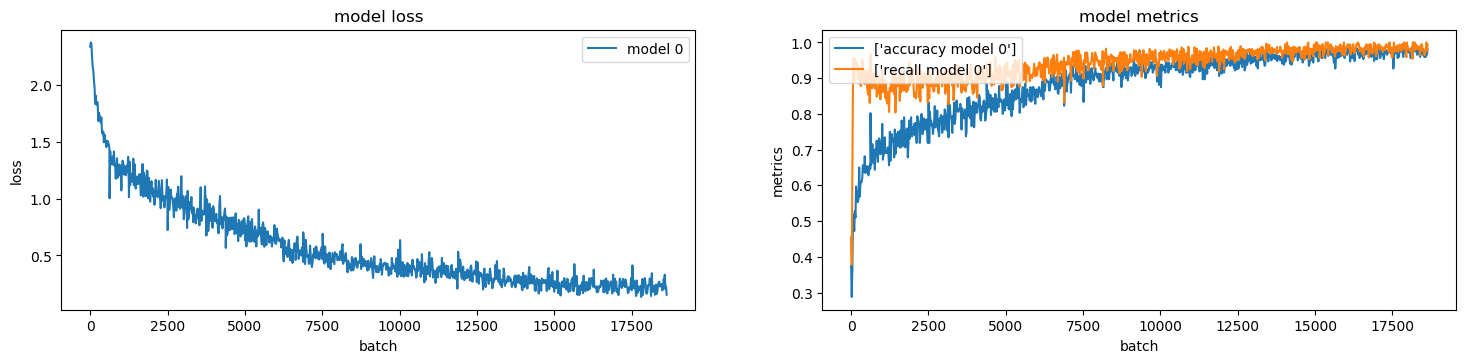

model 0      Step: 14s170ms | Loss: 0.202   | accuracy: 96.875% ,recall: 99.444%  | learning rate: 3.125e-05 | epoch: 29  ( 500/626 )
model 0      Step: 12s504ms | Loss: 0.238   | accuracy: 96.875% ,recall: 96.905%  | learning rate: 3.125e-05 | epoch: 29  ( 520/626 )
model 0      Step: 12s723ms | Loss: 0.244   | accuracy: 96.875% ,recall: 99.444%  | learning rate: 3.125e-05 | epoch: 29  ( 540/626 )
model 0      Step: 15s613ms | Loss: 0.282   | accuracy: 96.250% ,recall: 98.490%  | learning rate: 3.125e-05 | epoch: 29  ( 560/626 )
model 0      Step: 13s664ms | Loss: 0.247   | accuracy: 96.562% ,recall: 97.569%  | learning rate: 3.125e-05 | epoch: 29  ( 580/626 )


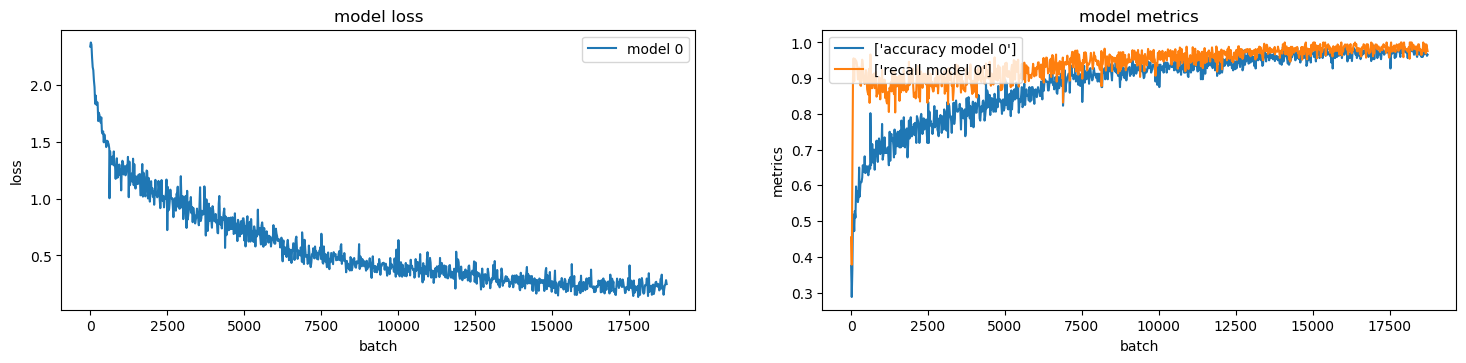

model 0      Step: 14s93ms  | Loss: 0.132   | accuracy: 98.750% ,recall: 99.167%  | learning rate: 3.125e-05 | epoch: 29  ( 600/626 )
model 0      Step: 15s378ms | Loss: 0.345   | accuracy: 95.312% ,recall: 97.946%  | learning rate: 3.125e-05 | epoch: 29  ( 620/626 )
model 0: out-of-sample evaluation:  accuracy: 87.500% ,recall: 100.000%


In [9]:
#執行訓練
plan.start_now()

In [10]:
effb0.class_names=dataset.class_names['zh-tw']

OrderedDict([('中性', (2, 0.7310103)), ('繪畫', (0, 0.1556251)), ('色情', (3, 0.11329336))])


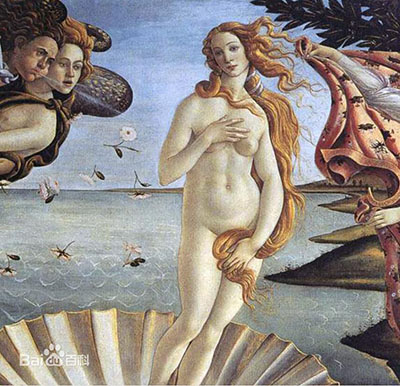

In [11]:
img=read_image('../images/venus.jpg')
print(effb0.infer_single_image('../images/venus.jpg',3))
img

OrderedDict([('繪畫', (0, 0.8097573)), ('色情漫畫', (1, 0.1002057)), ('中性', (2, 0.04806549))])


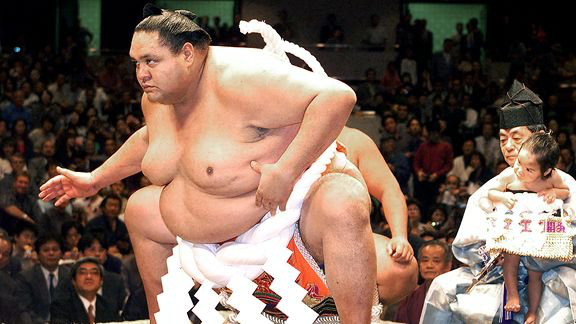

In [12]:
img=read_image('../images/sumo.jpg')
print(effb0.infer_single_image('../images/sumo.jpg',3))
img

OrderedDict([('性感', (4, 0.7996057)), ('中性', (2, 0.107523926)), ('色情漫畫', (1, 0.07180143))])


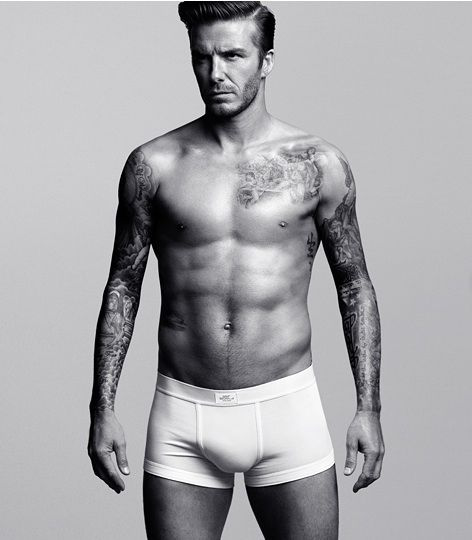

In [13]:
img=read_image('../images/beckham.jpg')
print(effb0.infer_single_image('../images/beckham.jpg',3))
img

OrderedDict([('色情漫畫', (1, 0.6671789)), ('色情', (3, 0.23581114)), ('繪畫', (0, 0.08719127))])


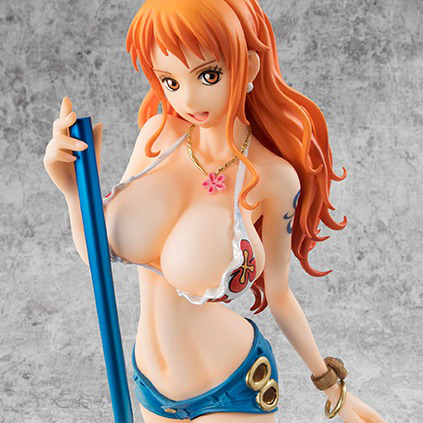

In [14]:
img=read_image('../images/nami.jpg')
print(effb0.infer_single_image('../images/nami.jpg',3))
img

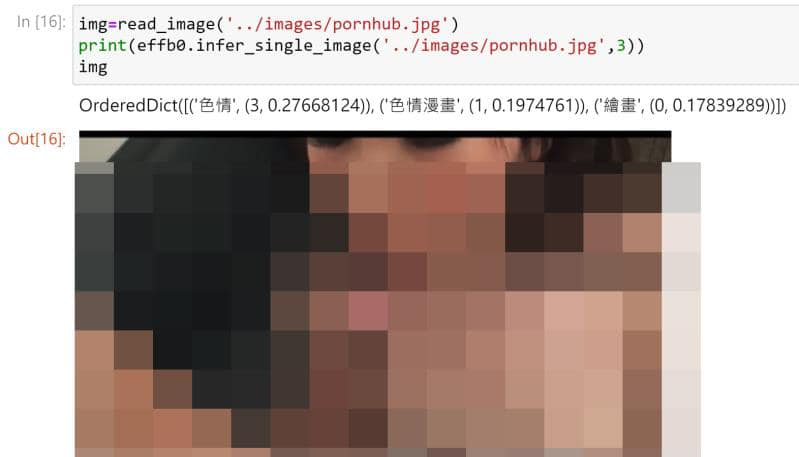

In [16]:
img=read_image('../images/pornhub.jpg')
img